In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad, jacfwd, jacrev, vjp
from jax import random
import numpy as np

key = random.PRNGKey(0)

# %set_env PATH_TO_JULIA

from functools import partial
from tqdm import tqdm

from julia.api import Julia
jl = Julia(compiled_modules=False)

from julia import Base
from julia import Main

diff_matrix_degree, diff_matrix_inv_, tau_degree, w_degree = Main.eval('include("LegendreRadau.jl"); get_diff_matrix()')

@partial(jit, static_argnums=(1,))
def interp_lag(t, k, tau_degrees):
	ans= 1.
	prod = 1.
	for i in range(tau_degrees.shape[0]):
		if i != k:
			ans *= (t-tau_degrees[i])
			prod *=(tau_degrees[k]-tau_degrees[i])
	return ans/prod

def compute_diff_matrix(tau_degree, a):
	jit_grad = partial(jit, static_argnums=(1,))(grad(interp_lag))
	return jnp.row_stack([jnp.row_stack([jit_grad(tau_degree[k], i, tau_degree) for k in range(a)]).T for i in range(a)])

@partial(jit, static_argnums=(1,))
def compute_diff2_matrix(tau_degree, a):
	jit_grad = partial(jit, static_argnums=(1,))(grad(grad(interp_lag)))
	return jnp.row_stack([jnp.row_stack([jit_grad(tau_degree[k], i, tau_degree) for k in range(a)]).T for i in range(a)])

diff_matrix_2_inv_ = {}
for a in tqdm(range(4, 99)):
	D2_ = diff_matrix_degree[str(a)] @ diff_matrix_degree[str(a)]
	D2_ =  np.array(D2_.T)
	D2_[:2, :] = 0.
	D2_[0, 0]  = 1.
	D2_[1, 1]  = 1.
	diff_matrix_2_inv_[str(a)] =  np.linalg.inv(D2_)

def precomp_lag_matrix(degree, tau):
    ans = np.ones((degree), dtype=jnp.float32)
    for i in range(degree):
        for k in range(degree):
            if k != i:
                ans[i] *= (tau[i]-tau[k])
    return ans

d_lag_vector = {a: precomp_lag_matrix(int(a), tau_degree[a]) for a in tau_degree.keys()}

@partial(jit, static_argnums=(3,4))
def compute_lagrange_interpo_jax(t_a, t_b, t_is, degree, n_points, tau, prod_):
    ans = jnp.zeros((degree, n_points))
    rescaled = (t_is - t_a) / (t_b - t_a)
    
    
    for i in range(degree):
        prods_i_ = jnp.prod(jnp.array([rescaled - tau[k] for k in range(degree) if k !=i]), axis=0)
        ans = ans.at[i,:].add(prods_i_ / prod_[i])
    
    return ans

@partial(jit, static_argnums=(3))
def compute_lagrange_interpo_jax(t_a, t_b, t_is, degree, tau, prod_):
    rescaled = (t_is - t_a) / (t_b - t_a)

    def compute_y(rescaled_i):
        ans = jnp.zeros((degree, 1))
        for i in range(degree):
            prods_i_ = jnp.prod(jnp.array([rescaled_i - tau[k] for k in range(degree) if k !=i]), axis=0)
            ans = ans.at[i,0].set(prods_i_ / prod_[i])
        return ans

    ans = vmap(compute_y, out_axes=1)(rescaled)[:,:,0]
    
    return ans

@partial(jit, static_argnums=(3))
def fn_compute_interpo(t_a, t_b, t_is, degree):
    return compute_lagrange_interpo_jax(t_a, t_b, t_is, degree, tau_degree[str(degree)], d_lag_vector[str(degree)])

fn_compute_interpo(0.,1., np.array([.1, .2, .4, .8, .5]), 10);
#Benchmark purposes
%timeit fn_compute_interpo(0.,1., np.array([.1, .2, .4, .8, .5]), 30);

100%|██████████| 95/95 [00:00<00:00, 1188.48it/s]


In [5]:
from scipy.integrate import solve_ivp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error
import time

In [91]:
#MODEL ZOO
def lorenz_coefs(library_dim):
    sigma, beta, rho = (10, 8 / 3, 28)
    true_coefs = np.zeros((3, library_dim))
    true_coefs[0, [1, 2]] = [-sigma, sigma]
    true_coefs[1, [1, 2, 6]] = [rho, -1, -1]
    true_coefs[2, [3, 5]] = [-beta, 1]
    return true_coefs

def duffing_dyn(t, x): 
    return [x[2], x[3], x[0] - (x[0]**3 + x[0]*x[1]**2), x[1] - (x[0]**2*x[1] + x[1]**3)]

def duffing_coefs(library_dim):
    true_coefs = np.zeros((4, library_dim))
    true_coefs[0, [3]] = [1]
    true_coefs[1, [4]] = [1]
    true_coefs[2, [1, 15, 19]] = [1, -1, -1]
    true_coefs[3, [2, 16, 25]] = [1, -1, -1]
    return true_coefs 

def rossler_dyn(t,x):
    p = (0.2, 0.2, 5.7)
    return [ -x[1] - x[2], x[0] + p[0] * x[1], p[1] + (x[0] - p[2]) * x[2] ]

def rossler_coefs(library_dim):
    p = (0.2, 0.2, 5.7)
    true_coefs = np.zeros((3, library_dim))
    true_coefs[0, [2, 3]] = [-1, -1]
    true_coefs[1, [1, 2]] = [1, p[0]]
    true_coefs[2, [0, 3, 6]] = [p[1], -p[2], 1]
    return true_coefs


def L96_N_F(n_state, forcing_term):
    @jit
    def L96(t,x):
        """Lorenz 96 model with constant forcing"""
        # Setting up vector
        d = jnp.zeros(n_state)
        # Loops over indices (with operations and Python underflow indexing handling edge cases)
        for i in range(n_state):
            d = d.at[i].set((x[(i + 1) % n_state] - x[i - 2]) * x[i - 1] - x[i] + forcing_term)
        return d
    return L96

def L96_N_F_x0(N,F):
    x0 = F * np.ones(N)  # Initial state (equilibrium)
    x0[0] += 0.01  # Add small perturbation to the first variable
    return x0


model_dict = {                                                                                     
                 'Lorenz96_40_8': { 'dynamic' : L96_N_F(40,8),
                            'init_cond' :  L96_N_F_x0(40,8),
                            'T': 1.,
                            'state_dim' : 40,
                            'degree_poly_dyn':2},
                 'Lorenz96_40_16': { 'dynamic' : L96_N_F(40,16),
                            'init_cond' :  L96_N_F_x0(40,16),
                            'T': 1.,
                            'state_dim' : 40,
                            'degree_poly_dyn':2},
                 'Lorenz96_40_32': { 'dynamic' : L96_N_F(40,32),
                            'init_cond' :  L96_N_F_x0(40,32),
                            'T': 1.,
                            'state_dim' : 40,
                            'degree_poly_dyn':2},
                 'Lorenz96_100_8': { 'dynamic' : L96_N_F(100,8),
                            'init_cond' :  L96_N_F_x0(100,8),
                            'T': 1.,
                            'state_dim' : 100,
                            'degree_poly_dyn':2},
                 'Lorenz96_200_8': { 'dynamic' : L96_N_F(200,8),
                            'init_cond' :  L96_N_F_x0(200,8),
                            'T': 1.,
                            'state_dim' : 200,
                            'degree_poly_dyn':2},
                'lorenz63': { 'dynamic' : lorenz,
                            'init_cond' : [1,1,1.],
                            'T':1.,
                            'state_dim' : 3,
                            'degree_poly_dyn':2}, 
                'rossler': { 'dynamic' : rossler_dyn,
                            'init_cond' : [5, 3, 0.],
                            'T':1.,
                            'state_dim' : 3,
                            'degree_poly_dyn':2},
                'duffing': { 'dynamic' : duffing_dyn,
                            'init_cond' : [2.1, 1.1, 2.1, 4.],
                            'T':.8,
                            'state_dim' : 4,
                            'degree_poly_dyn':3},}

In [17]:
class Output_Holder:
	def __init__(self) -> None:
		self.denoise_stats = {}
		self.ts_gd = None
		self.ts_array = None
		self.ts_l_x_array = None	
		self.results = {}

	def serialize(self, dir):
		pass

output_holder = Output_Holder()

In [120]:
from sklearn.linear_model import LinearRegression, Ridge
import numpy as np
from tqdm import tqdm

# build set of filtered points
def denoise(t_0, X, T, N, dt, step, maxT):
	Delta = step
	N_steps = int(round((maxT-t_0-T)/Delta,  ndigits=4))+1
	dim_state=X.shape[0]

	x_t = []
	x_t_2 = []
	l_coefs_dim = [[] for i in range(dim_state)]
	l_ans = []

	for k in tqdm(range(N_steps)):
		lb = t_0 + k * step
		ub = t_0 + k * step + T
		
		t_l = np.array([a  for a in np.arange(t_0, maxT , dt) if a< ub and a>= lb])
		x_t.extend(t_l[5:-5])
		x_t_2.extend(tau_degree[str(N)]*T+lb)
		Am = fn_compute_interpo(lb, ub, t_l, N).T
		l_ans_dim = []
		for dim in range(dim_state):
			pt_l  = np.array([X[dim, i] for i,a in enumerate(np.arange(t_0, maxT , dt)) if a< ub and a>= lb])
			lin_reg = LinearRegression(fit_intercept=False)
			lin_reg.fit(Am, pt_l)
			# We add every denoised observation in this version
			l_coefs_dim[dim].extend((Am @ lin_reg.coef_)[5:-5])
			l_ans_dim.append(lin_reg.coef_)
		l_ans.append(l_ans_dim)
	return x_t, x_t_2, l_coefs_dim, l_ans

# Build a set of points
def regression_points(t_0, x_t, l_coefs_dim, T, N, step, max_T):
	pd_reg = pd.DataFrame(np.array([x_t , *l_coefs_dim]).T)
	delta = step
	n_steps = int(round((max_T-T)/delta,  ndigits=4))+1
	dim_state= len(l_coefs_dim)

	x_t = []
	l_ans = []

	for k in tqdm(range(4,n_steps-4)):
		lb = max(t_0 + k * step, 0)
		ub = min(t_0 + k * step + T, maxT)
		
		filtered = pd_reg[(pd_reg[0] <= ub) & (pd_reg[0] >= lb)]
		t_l = filtered[0].values
		x_t.extend(tau_degree[str(N)]*T+lb)
		Am = fn_compute_interpo(lb, ub, t_l, N).T
		l_ans_dim = []
		for dim in range(dim_state):
			pt_l  = filtered[dim+1]
			lin_reg = LinearRegression(fit_intercept=False)
			lin_reg.fit(Am, pt_l)
			l_ans_dim.append(lin_reg.coef_)
		l_ans.append(l_ans_dim)
	return x_t, l_ans

 
model_name = 'lorenz63'

current_dynamic = model_dict[model_name]['dynamic']
T= model_dict[model_name]['T']
model_matrix = model_dict[model_name]['model_matrix']

init_cond = model_dict[model_name]['init_cond']

state_dim = model_dict[model_name]['state_dim']
degree_poly_dyn=2
dt = .005
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-7
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-7
maxT = 100.
tspan =(0,maxT)

X_ref = solve_ivp(current_dynamic, tspan, init_cond, t_eval=np.arange(tspan[0], tspan[1],  dt), **integrator_keywords).y
mean_norm = np.sqrt(np.mean(np.linalg.norm(X_ref)**2))/np.sqrt(X_ref.shape[-1]*X_ref.shape[0])

#corrupt by noise
noise_level = .1
X_measures = X_ref + np.random.normal(scale=noise_level*mean_norm, size=X_ref.shape)
T=1.
N=30
step = .5
x_t, x_t_2, l_coefs_dim, l_ans = denoise(0., X_measures, T, N, dt, step, maxT)

T=1.
N=30
step = .2

x_2, l_coef_2_dim = regression_points(0., x_t, l_coefs_dim, T, N, step, maxT)

l_x_t = np.array(l_coef_2_dim)

# useful for the partially observed
np.save('subtraj.npy', l_x_t)
np.save('d_inv.npy', diff_matrix_inv_[str(N)])

100%|██████████| 599/599 [03:07<00:00,  3.19it/s]


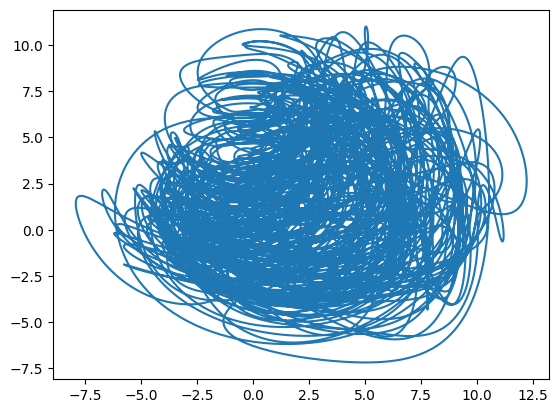

In [72]:
#LORENZ 96, 40 F=20
plt.plot(X_ref[0,:], X_ref[1,:])

In [217]:
d_stats={}
d_stats['obs_error_pct'] = np.linalg.norm(X_measures - X_ref)/ np.linalg.norm(X_ref) * 100
print('obs',  d_stats['obs_error_pct'])
X_ref_m = solve_ivp(current_dynamic, tspan, init_cond, t_eval=sorted(x_t_2), **integrator_keywords).y
sorted_indices = np.argsort(x_t_2)
reverse_indices = np.argsort(sorted_indices)

d_stats['ridge_error_pct'] = np.linalg.norm(np.transpose(np.array(l_ans), (1,0,2)).reshape((state_dim,-1)) - X_ref_m[:, reverse_indices])/ np.linalg.norm(X_ref_m) *100
print('w/o filtering',  d_stats['ridge_error_pct'])

X_ref_m = solve_ivp(current_dynamic, tspan, init_cond, t_eval=sorted(x_2), **integrator_keywords).y
sorted_indices = np.argsort(x_2)
reverse_indices = np.argsort(sorted_indices)
d_stats['filtered_error_pct'] = np.linalg.norm(np.transpose(l_coef_2_dim,(1,0,2)).reshape((state_dim,-1)) - X_ref_m[:, reverse_indices])/ np.linalg.norm(X_ref_m)*100
print('filtered ridge', d_stats['filtered_error_pct'] )

obs 9.7600010911485
w/o filtering 11.864574698785411
filtered ridge 3.5368701061045247


Learning Fully observed

In [25]:
import random
from typing import Tuple

import optax
import jax.numpy as jnp
import jax
import numpy as np
import haiku as hk

In [26]:
class MonomialLayer(hk.Module):
    def __init__(self, degree, n):
        super().__init__()
        self.degree = degree
        self.n = n
    
    def __call__(self, x):
        monomials =  [jnp.power(x[:, :, 0], 0)] #[]
        for d in range(1, self.degree + 1):
            for i in range(self.n):
                monomials.append(jnp.power(x[:, :, i], d))
            for i in range(self.n):
                for j in range(i + 1, self.n):
                    for k in range(d-1, 0, -1):
                        monomials.append(jnp.power(x[:, :, i], k) * jnp.power(x[:, :, j], d-k))
        return jnp.stack(monomials, axis=-1)

In [40]:
class PolynomialRegressor(hk.Module):
    def __init__(self, degree, dim_system):
        super().__init__()
        self.monomials = MonomialLayer(degree,dim_system) 
        self.lay1 = hk.Linear(dim_system, w_init=hk.initializers.RandomNormal(.01), with_bias=False)

    def __call__(self, x):
        y = self.monomials(x)
        y = self.lay1(y)
        return y
    
@jax.jit
def forward_poly(x):
  model = PolynomialRegressor(2, 3)
  return model(x)

forward_po = hk.transform(forward_poly)


l_x_t_t = np.transpose(l_x_t,(0,2,1)) # subinterval, LGR, components at LGR
x = l_x_t_t
key = hk.PRNGSequence(42)
params = forward_po.init(next(key), x)

y = forward_po.apply(params, None, x)

def wrap_poly(params):
  def f(x):
    return forward_po.apply(params, None, x)
  return f

f_poly = jax.jit(wrap_poly(params))
y = f_poly(x)
#benchmark
%timeit y = f_poly(x)

129 µs ± 2.55 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [307]:
class NNetRegressor(hk.Module):
    def __init__(self):
        super().__init__()
        self.lay2 = hk.Sequential([hk.Linear(300, w_init=hk.initializers.RandomNormal(.01)), jax.nn.relu])
        self.lay3 = hk.Sequential([hk.Linear(300, w_init=hk.initializers.RandomNormal(.01)), jax.nn.relu])
        self.lay1 = hk.Linear(3, w_init=hk.initializers.RandomNormal(.01), with_bias=False)

    def __call__(self, x):
        y = self.lay2(x)
        y = jax.nn.relu(self.lay3(y) + y)
        y = jax.nn.relu(self.lay3(y) + y)
        y = self.lay1(y)
        return y

In [ ]:
from typing import Iterator, NamedTuple
import copy

# params of the model and state of the optimizer
class TrainingState(NamedTuple):
  params: hk.Params
  opt_state: optax.OptState

# batching placeholder
class Batch(NamedTuple):
  x: np.ndarray  # [a, K, N]

class BatchIterator:
  def __init__(self, x: np.ndarray, 
    shuffle: bool,
    batch_size: int):
    self.x = x
    self.shuffle = shuffle
    self.batch_size = batch_size
    self.curr = 0

  def __iter__(self, ):
    self.curr = 0
    return self

  def __next__(self):
    if self.shuffle:
      return Batch(x=self.x[np.random.choice(x.shape[0], size=self.batch_size, replace=True),:,:])
    else:
      a = self.curr
      b = min(self.curr + self.batch_size, x.shape[0]-1)
      if a==b:
        raise StopIteration
      else:
        self.curr = b
        return Batch(x=self.x[a:b,:,:])

polynomial_training = True
def dyn_poly(x: jax.Array) -> jax.Array:
    if polynomial_training:
      model = PolynomialRegressor(2,3)
    else:
      model = NNetRegressor()
    return model(x)

network = hk.without_apply_rng(hk.transform(dyn_poly))
optimizer = optax.adam(1e-3)

network_forward = jax.jit(network.apply)

def compute_params_norm(param):
    norm = 0.0

    if isinstance(param, dict):
        # Iterate over the items in the nested dictionary
        for key, value in param.items():
            norm += compute_params_norm(value)  # Recursively compute norm for nested values
    else:
        # Compute the positive and negative parts of the parameter array
        pos_part = jax.nn.relu(param)
        neg_part = jax.nn.relu(-param)

        # Accumulate the L1 norm of the parameter array
        norm = jnp.sum(pos_part) + jnp.sum(neg_part)

    return norm

@jax.jit
def loss(params: hk.Params, batch: Batch) -> jax.Array:
    x= batch.x
    
    f_pred = network_forward(params, x[:,1:,:])

    @jax.jit
    def interval_loss(x_int, f_x_int):
      y= jnp.dot(diff_matrix_inv_[1:, 1:], f_x_int)+ x_int[0, 1:41][jnp.newaxis, :] - x_int[1:, 1:41]
      return 1/(y.shape[0]) * jnp.linalg.norm(y)**2


    a = jnp.mean(jax.vmap(interval_loss, in_axes=[0,0])(x, f_pred))


    l1 = 0.005* compute_params_norm(params)
    return a + l1

@jax.jit
def evaluate(params: hk.Params, batch: Batch) -> jax.Array:
  return loss(params, batch)

grad_loss_jitted = jax.jit(jax.grad(loss))
@jax.jit
def update(state: TrainingState, batch: Batch) -> TrainingState:
  grads = grad_loss_jitted(state.params, batch)
  updates, opt_state = optimizer.update(grads, state.opt_state)
  params = optax.apply_updates(state.params, updates)
  return TrainingState(params, opt_state)


# Initialise network and optimiser; note we draw an input to get shapes.
initial_params = network.init(
    jax.random.PRNGKey(seed=0), l_x_t_t[:1,:,:])
initial_opt_state = optimizer.init(initial_params)
state = TrainingState(initial_params, initial_opt_state)

l = []
currBest_value=np.inf
currBest_sol= None
for epoch in zip([30, 100, 300, 300], [60001, 50001, 30001, 30001, 30001], range(5)):
  itDS = iter(BatchIterator(l_x_t_t, True, epoch[0]))
  # Training & evaluation loop.
  for step in range(epoch[1]):
    if step % 100 == 0 :
      loss_value = np.array(evaluate(state.params, Batch(x=l_x_t_t)))
      print(f"step: {step}, loss: {loss_value:.3f}", end='\r')
      l.append(loss_value)
      if loss_value < currBest_value:
        currBest_value = loss_value
        currBest_sol = copy.deepcopy(state.params)
    # Do SGD on a batch of training examples.
    state = update(state, next(itDS))
  print(f"epoch {epoch[2]}: loss: {np.array(evaluate(state.params, Batch(x=l_x_t_t))):.3f}                      ")

for epoch in zip([30, 100, 300, 300], [60001, 50001, 30001, 30001, 30001], range(5)):
  itDS = iter(BatchIterator(l_x_t_t, True, epoch[0]))
  # Training & evaluation loop.
  for step in range(epoch[1]):
    if step % 100 == 0 :
      loss_value = np.array(evaluate(state.params, Batch(x=l_x_t_t)))
      print(f"step: {step}, loss: {loss_value:.3f}", end='\r')
      l.append(loss_value)
      if loss_value < currBest_value:
        currBest_value = loss_value
        currBest_sol = copy.deepcopy(state.params)
    # Do SGD on a batch of training examples.
    state = update(state, next(itDS))
  print(f"epoch {epoch[2]}: loss: {np.array(evaluate(state.params, Batch(x=l_x_t_t))):.3f}                      ")


In [ ]:
# check best solution, sparsify using thresholding
currBest_value, currBest_sol['polynomial_regressor/~/linear']['w']* (abs(currBest_sol['polynomial_regressor/~/linear']['w'])>1e-2)

In [90]:
lorenz_matrix = np.array([[ 0.       ,  0.       ,  0.       ],
						[-10         ,    28.    ,  0.       ],
						[ 10         ,    -1     ,  0.       ],
						[ 0.         ,  0.       , -8./3.],
						[ 0.         ,  0.       ,  0.       ],
						[ 0.         ,  0.       ,  0.       ],
						[ 0.         ,  0.       ,  0.       ],
						[ 0.         ,  0.       ,  1.],
						[ 0.         , -1,  0.       ],
						[ 0.         ,  0.       ,  0.       ]])

In [ ]:
# case of the Lorenz
ground_truth = copy.deepcopy(currBest_sol)
ground_truth['polynomial_regressor/~/linear']['w'] = lorenz_matrix
f_l  = network_forward(currBest_sol, l_x_t_t)
f_tr = network_forward(ground_truth, l_x_t_t)
v = abs(f_l -f_tr)/ (np.linalg.norm(f_tr, axis=-1)[:,:,np.newaxis])

output_holder.results['rmse_deriv'] = float(np.mean(v)*100)
output_holder.results['rmse_std'] = float(np.std(v)*100)
output_holder.results['rmse_q5']  = np.quantile(v, .05)* 100
output_holder.results['rmse_q10'] = np.quantile(v, .10)* 100
output_holder.results['rmse_q90'] = np.quantile(v, .90)* 100
output_holder.results['rmse_q95'] = np.quantile(v, .95)* 100
output_holder.results

# Version with LASSO type regularization

In [ ]:
from typing import Iterator, NamedTuple
import copy

class TrainingState(NamedTuple):
  params: hk.Params
  opt_state: optax.OptState

class Batch(NamedTuple):
  x: np.ndarray  # [a, K, N]

class BatchIterator:
  def __init__(self, x: np.ndarray, 
    shuffle: bool,
    batch_size: int):
    self.x = x
    self.shuffle = shuffle
    self.batch_size = batch_size
    self.curr = 0

  def __iter__(self, ):
    self.curr = 0
    return self

  def __next__(self):
    if self.shuffle:
      return Batch(x=self.x[np.random.choice(x.shape[0], size=self.batch_size, replace=True),:,:])
    else:
      a = self.curr
      b = min(self.curr + self.batch_size, x.shape[0]-1)
      if a==b:
        raise StopIteration
      else:
        self.curr = b
        return Batch(x=self.x[a:b,:,:])

def dyn_poly(x: jax.Array) -> jax.Array:
    if polynomial_training:
      model = PolynomialRegressor(3)
    else:
      model = NNetRegressor()
    return model(x)

network = hk.without_apply_rng(hk.transform(dyn_poly))
optimizer = optax.adam(1e-3)

network_forward = jax.jit(network.apply)

def compute_params_norm(param):
    norm = 0.0

    if isinstance(param, dict):
        # Iterate over the items in the nested dictionary
        for key, value in param.items():
            norm += compute_params_norm(value)  # Recursively compute norm for nested values
    else:
        # Compute the positive and negative parts of the parameter array
        pos_part = jax.nn.relu(param)
        neg_part = jax.nn.relu(-param)

        # Accumulate the L1 norm of the parameter array
        norm = jnp.sum(pos_part) + jnp.sum(neg_part)

    return norm

@jax.jit
def loss(params: hk.Params, batch: Batch) -> jax.Array:
    x= batch.x
    
    f_pred = network_forward(params, x[:,1:,:])

    @jax.jit
    def interval_loss(x_int, f_x_int):
      y= jnp.dot(diff_matrix_inv_[1:, 1:], f_x_int)+ x_int[0, :][jnp.newaxis, :] - x_int[1:, :]
      return 1/(y.shape[0]) * jnp.linalg.norm(y)**2


    a = jnp.mean(jax.vmap(interval_loss, in_axes=[0,0])(x, f_pred))


    l1 = 0.005* compute_params_norm(params)
    return a + l1

@jax.jit
def evaluate(params: hk.Params, batch: Batch) -> jax.Array:
  return loss(params, batch)

grad_loss_jitted = jax.jit(jax.grad(loss))
@jax.jit
def update(state: TrainingState, batch: Batch) -> TrainingState:
  grads = grad_loss_jitted(state.params, batch)
  updates, opt_state = optimizer.update(grads, state.opt_state)
  params = optax.apply_updates(state.params, updates)
  return TrainingState(params, opt_state)


# Initialise network and optimiser; note we draw an input to get shapes.
initial_params = network.init(
    jax.random.PRNGKey(seed=0), l_x_t_t[:1,:,:])
initial_opt_state = optimizer.init(initial_params)
state = TrainingState(initial_params, initial_opt_state)

l = []
currBest_value=np.inf
currBest_sol= None
for epoch in zip([30, 100, 300, 300], [60001, 50001, 30001, 30001, 30001], range(5)):
  itDS = iter(BatchIterator(l_x_t_t, True, epoch[0]))
  # Training & evaluation loop.
  for step in range(epoch[1]):
    if step % 100 == 0 :
      loss_value = np.array(evaluate(state.params, Batch(x=l_x_t_t)))
      print(f"step: {step}, loss: {loss_value:.3f}", end='\r')
      l.append(loss_value)
      if loss_value < currBest_value:
        currBest_value = loss_value
        currBest_sol = copy.deepcopy(state.params)
    # Do SGD on a batch of training examples.
    state = update(state, next(itDS))
  print(f"epoch {epoch[2]}: loss: {np.array(evaluate(state.params, Batch(x=l_x_t_t))):.3f}                      ")

import time

last_enhanced = -1
last_epoch_enhanced = -1
flag_early_stop = False
start = time.clock()
for epoch in zip([30, 100, 300, 300], [60001, 50001, 30001, 30001, 30001], range(5)):
    itDS = iter(BatchIterator(l_x_t_t, True, epoch[0]))
      # Training & evaluation loop.
    for step in range(epoch[1]):
        if step % 100 == 0 :
            loss_value = np.array(evaluate(state.params, Batch(x=l_x_t_t)))
            print(f"step: {step}, loss: {loss_value:.3f}", end='\r')
            l.append(loss_value)
            if loss_value < currBest_value:
                currBest_value = loss_value
                currBest_sol = copy.deepcopy(state.params)
                last_epoch_enhanced = epoch[2]
                last_enhanced = step

        if last_epoch_enhanced == epoch[2] and last_enhanced > step+2000:
            flag_early_stop= True
            break
        
        if last_epoch_enhanced != epoch[2] and step > 2000:
            flag_early_stop= True
            break
    if flag_early_stop:
        print('early stop')
        break

    # Do SGD on a batch of training examples.
    state = update(state, next(itDS))

output_holder.results['computation_time'] =  time.time() - start


In [244]:
ground_truth = copy.deepcopy(currBest_sol)
ground_truth['polynomial_regressor/~/linear']['w'] = lorenz_matrix
f_l  = network_forward(currBest_sol, l_x_t_t)

f_tr = network_forward(ground_truth, l_x_t_t)
v = abs(f_l -f_tr)/ (np.linalg.norm(f_tr, axis=-1)[:,:,np.newaxis])

output_holder.results['mio_rmse_deriv'] = float(np.mean(v)*100)
output_holder.results['mio_rmse_std'] = float(np.std(v)*100)
output_holder.results['mio_rmse_q5']  = np.quantile(v, .05)* 100
output_holder.results['mio_rmse_q10'] = np.quantile(v, .10)* 100
output_holder.results['mio_rmse_q90'] = np.quantile(v, .90)* 100
output_holder.results['mio_rmse_q95'] = np.quantile(v, .95)* 100
output_holder.results

{'coef_err': 3.0853005435283793,
 'rmse_deriv': 2.39205265045166,
 'rmse_std': 1.8409416675567627,
 'rmse_q5': 0.17653828137554228,
 'rmse_q10': 0.3722741873934865,
 'rmse_q90': 5.028549842536449,
 'rmse_q95': 5.9603277035057545,
 'mio_rmse_deriv': 2.2068774700164795,
 'mio_rmse_std': 1.7831180095672607,
 'mio_rmse_q5': 0.16787689703051,
 'mio_rmse_q10': 0.3329375688917935,
 'mio_rmse_q90': 4.75306399166584,
 'mio_rmse_q95': 5.775983780622481}